In [1]:
import transformers as T
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from torchmetrics import SpearmanCorrCoef, Accuracy, F1Score

In [2]:
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [3]:
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        self.data = load_dataset(
            "sem_eval_2014_task_1", split=split, cache_dir="./cache/", trust_remote_code=True
        ).to_list()

    def __getitem__(self, index):
        d = self.data[index]
        # Token replacement
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
        return d

    def __len__(self):
        return len(self.data)

data_sample = SemevalDataset(split="train").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

Generating train split:   0%|          | 0/4500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset example: 
{'sentence_pair_id': 1, 'premise': 'A group of kids is playing in a yard and an old man is standing in the background', 'hypothesis': 'A group of boys in a yard is playing and a man is standing in the background', 'relatedness_score': 4.5, 'entailment_judgment': 0} 
{'sentence_pair_id': 2, 'premise': 'A group of children is playing in the house and there is no man standing in the background', 'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background', 'relatedness_score': 3.200000047683716, 'entailment_judgment': 0} 
{'sentence_pair_id': 3, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'The kids are playing outdoors near a man with a smile', 'relatedness_score': 4.699999809265137, 'entailment_judgment': 1}


In [4]:
# Define the hyperparameters
bert_lr = 3e-5
task_lr = 3e-3
epochs = 5
train_batch_size = 64
validation_batch_size = 64
test_batch_size = 64

In [5]:
tokenizer = T.BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "mps" if torch.backends.mps.is_available() else "cpu"

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokens and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.
    pair_ids = [example['sentence_pair_id'] for example in batch]
    complete_texts = [
        f"{example['premise']}[SEP]{example['hypothesis']}"
        for example in batch
    ]
    data = tokenizer.batch_encode_plus(
        complete_texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        add_special_tokens=False,
    )
    data['pair_ids'] = torch.tensor(pair_ids)
    data['labels_reg'] = torch.tensor([b['relatedness_score'] for b in batch])
    data['labels_cls'] = torch.tensor([b['entailment_judgment'] for b in batch])
    
    # Move the data to the device
    data = {k: data[k].to(device) for k in data}
    
    return data

# TODO1-2: Define your DataLoader
ds_train = SemevalDataset("train")
ds_validation = SemevalDataset("validation")
ds_test = SemevalDataset("test")

dl_train = DataLoader(ds_train, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
dl_validation = DataLoader(ds_validation, batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn)
dl_test = DataLoader(ds_test, batch_size=test_batch_size, shuffle=False, collate_fn=collate_fn)

In [7]:
# TODO2: Construct your model
class MultiLabelModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
        self.regression_head = torch.nn.Sequential(
            torch.nn.Linear(768, 384),
            torch.nn.ReLU(),
            torch.nn.Linear(384, 192),
            torch.nn.ReLU(),
            torch.nn.Linear(192, 1)
        )
        self.classification_head = torch.nn.Sequential(
            torch.nn.Linear(768, 384),
            torch.nn.ReLU(),
            torch.nn.Linear(384, 192),
            torch.nn.ReLU(),
            torch.nn.Linear(192, 3)
        )
        
    def forward(self, **inputs):
        # Write your code here
        # Forward pass
        # BERT
        bert_output = self.bert(inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'])
        # [CLS] token hidden state
        cls_token_output = bert_output.last_hidden_state[:, 0, :]
        # Task-specific heads
        reg_output = self.regression_head(cls_token_output)
        cls_output = self.classification_head(cls_token_output)

        return reg_output.squeeze(-1), cls_output

In [8]:
# Use both GPUs
model = MultiLabelModel()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
# TODO3: Define your optimizer and loss function

# TODO3-1: Define your Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)# Write your code here
optimizer = torch.optim.AdamW([
    {'params': model.bert.parameters(), 'lr': bert_lr},
    {'params': model.regression_head.parameters(), 'lr': task_lr},
    {'params': model.classification_head.parameters(), 'lr': task_lr}
])

# TODO3-2: Define your loss functions (you should have two)
# Write your code here
criterion_reg = torch.nn.MSELoss()  # Regression loss
criterion_cls = torch.nn.CrossEntropyLoss()  # Classification loss

# scoring functions
spc = SpearmanCorrCoef().to(device)
acc = Accuracy(task="multiclass", num_classes=3).to(device)
f1 = F1Score(task="multiclass", num_classes=3, average='macro').to(device)

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [10]:
# This is the sample code from Pytorch
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
    
model = model.to(device)

Let's use 2 GPUs!


In [11]:
%mkdir ./saved_models

In [12]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    # TODO4: Write the training loop
    # Write your code here
    for inputs in pbar:
        # train your model
        # clear gradient
        optimizer.zero_grad()
        # forward pass
        outputs_reg, outputs_cls = model(**inputs)
        # compute loss
        loss_reg = criterion_reg(outputs_reg, inputs['labels_reg'])
        loss_cls = criterion_cls(outputs_cls, inputs['labels_cls'])
        # back-propagation
        loss = loss_reg + loss_cls
        loss.backward()
        # model optimization
        optimizer.step()
        # update progress bar
        pbar.set_postfix(loss=loss.item())

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    # TODO5: Write the evaluation loop
    # Write your code here
    for inputs in pbar:
        # Evaluate your model
        outputs_reg, outputs_cls = None, None
        with torch.no_grad():
            outputs_reg, outputs_cls = model(**inputs)
        # Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
        pred_reg = outputs_reg
        pred_cls = outputs_cls.argmax(dim=1)
        spc.update(pred_reg, inputs['labels_reg'])
        acc.update(pred_cls, inputs['labels_cls'])
        f1.update(pred_cls, inputs['labels_cls'])

    # Print the evaluation scores
    print(f'Spearman CorrCoef: {spc.compute()}')
    print(f'Accuracy: {acc.compute()}')
    print(f'F1 Score: {f1.compute()}')
    # Reset the evaluation metrics
    spc.reset()
    acc.reset()
    f1.reset()
    # Save the model
    torch.save(model, f'./saved_models/ep{ep}.ckpt')

Training epoch [1/5]:   0%|          | 0/71 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation epoch [1/5]: 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]


Spearman CorrCoef: 0.7556335926055908
Accuracy: 0.7739999890327454
F1 Score: 0.7754938006401062


Validation epoch [2/5]: 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


Spearman CorrCoef: 0.8027445077896118
Accuracy: 0.8399999737739563
F1 Score: 0.839614748954773


Validation epoch [3/5]: 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


Spearman CorrCoef: 0.8060958385467529
Accuracy: 0.8500000238418579
F1 Score: 0.8496143817901611


Validation epoch [4/5]: 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


Spearman CorrCoef: 0.8084450364112854
Accuracy: 0.828000009059906
F1 Score: 0.833550214767456


Validation epoch [5/5]: 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]


Spearman CorrCoef: 0.8181919455528259
Accuracy: 0.8600000143051147
F1 Score: 0.855156660079956


In [13]:
# Test the model on the test set
pbar = tqdm(dl_test)
for inputs in pbar:
    # Evaluate your model
    outputs_reg, outputs_cls = None, None
    with torch.no_grad():
        outputs_reg, outputs_cls = model(**inputs)
    # Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
    pred_reg = outputs_reg
    pred_cls = outputs_cls.argmax(dim=1)
    spc.update(pred_reg, inputs['labels_reg'])
    acc.update(pred_cls, inputs['labels_cls'])
    f1.update(pred_cls, inputs['labels_cls'])

# Print the evaluation scores
print(f'Spearman CorrCoef: {spc.compute()}')
print(f'Accuracy: {acc.compute()}')
print(f'F1 Score: {f1.compute()}')

# Reset the evaluation metrics
spc.reset()
acc.reset()
f1.reset()

100%|██████████| 77/77 [00:09<00:00,  8.20it/s]

Spearman CorrCoef: 0.8057330846786499
Accuracy: 0.8441241979598999
F1 Score: 0.8330100774765015


# Error Analysis

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [43]:
results_df = pd.DataFrame.from_dict(ds_test.data).set_index('sentence_pair_id')
results_df

,premise,hypothesis,relatedness_score,entailment_judgment
sentence_pair_id,,,,
6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,3.300,0
7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,3.700,0
8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,3.000,0
10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,4.900,1
11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,3.665,0
...,...,...,...,...
9991,The young girl is blowing a bubble that is huge,There is no girl in pink twirling a ribbon,2.100,0
9992,A dog in a colored coat is running across the ...,The flute is being played by one man,1.000,0
9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.000,0


In [46]:
# Evaluate the model on the test set
pbar = tqdm(dl_test)
for inputs in pbar:  # Track the index with enumerate
    # Evaluate your model
    outputs_reg, outputs_cls = None, None
    with torch.no_grad():
        outputs_reg, outputs_cls = model(**inputs)
    
    # Get predictions
    pred_reg = outputs_reg
    pred_cls = outputs_cls.argmax(dim=1)

    # Record the results in a DataFrame
    for i, pair_id in enumerate(inputs['pair_ids']):
        results_df.loc[pair_id.item(), 'pred_reg'] = pred_reg[i].item()
        results_df.loc[pair_id.item(), 'pred_cls'] = int(pred_cls[i].item())

    # Update evaluation metrics
    spc.update(pred_reg, inputs['labels_reg'])
    acc.update(pred_cls, inputs['labels_cls'])
    f1.update(pred_cls, inputs['labels_cls'])

# Print the evaluation scores
print(f'Spearman CorrCoef: {spc.compute()}')
print(f'Accuracy: {acc.compute()}')
print(f'F1 Score: {f1.compute()}')

# Reset the evaluation metrics
spc.reset()
acc.reset()
f1.reset()

100%|██████████| 77/77 [00:11<00:00,  6.57it/s]

Spearman CorrCoef: 0.8057330846786499
Accuracy: 0.8441241979598999
F1 Score: 0.8330100774765015


## Overvall

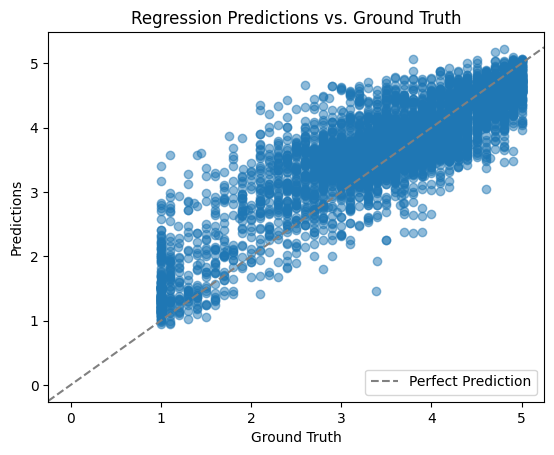

In [48]:
plt.scatter(results_df['relatedness_score'], results_df['pred_reg'], alpha=0.5)
plt.title("Regression Predictions vs. Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='Perfect Prediction')  # Reference line
plt.legend(loc='lower right')
plt.show()

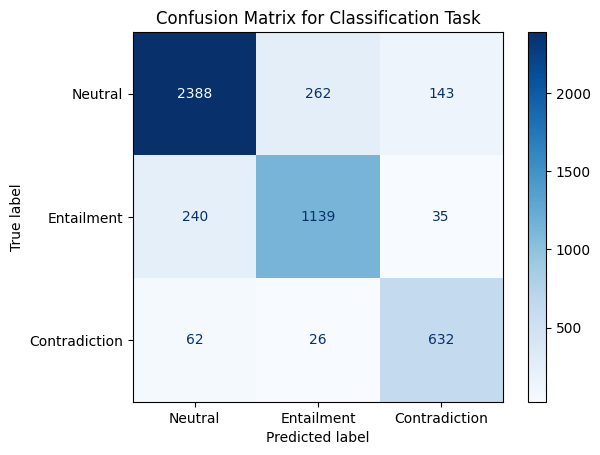

In [49]:
# Generate the confusion matrix
cm = confusion_matrix(results_df['entailment_judgment'], results_df['pred_cls'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Entailment', 'Contradiction'])
disp.plot(cmap='Blues')  # You can change the colormap if needed
plt.title("Confusion Matrix for Classification Task")
plt.show()

## Regression -> Classification

In [50]:
reg_filt = (results_df['relatedness_score'] - results_df['pred_reg']).abs() >= 1
reg_upr_filt = reg_filt & ((results_df['relatedness_score'] - results_df['pred_reg']) < 0) # Pred > Target
reg_lwr_filt = reg_filt & ((results_df['relatedness_score'] - results_df['pred_reg']) > 0) # Pred < Target

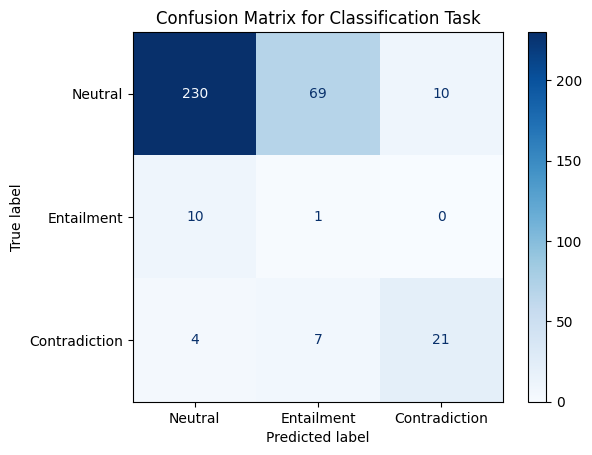

In [51]:
# Generate the confusion matrix
cm = confusion_matrix(results_df[reg_filt]['entailment_judgment'], results_df[reg_filt]['pred_cls'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Entailment', 'Contradiction'])
disp.plot(cmap='Blues')  # You can change the colormap if needed
plt.title("Confusion Matrix for Classification Task")
plt.show()

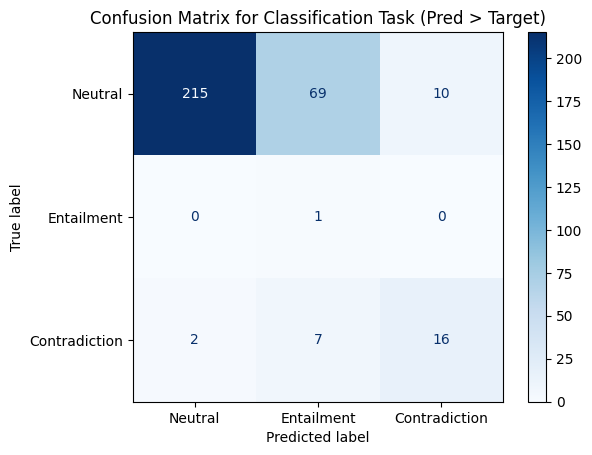

In [52]:
# Generate the confusion matrix
cm = confusion_matrix(results_df[reg_upr_filt]['entailment_judgment'], results_df[reg_upr_filt]['pred_cls'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Entailment', 'Contradiction'])
disp.plot(cmap='Blues')  # You can change the colormap if needed
plt.title("Confusion Matrix for Classification Task (Pred > Target)")
plt.show()

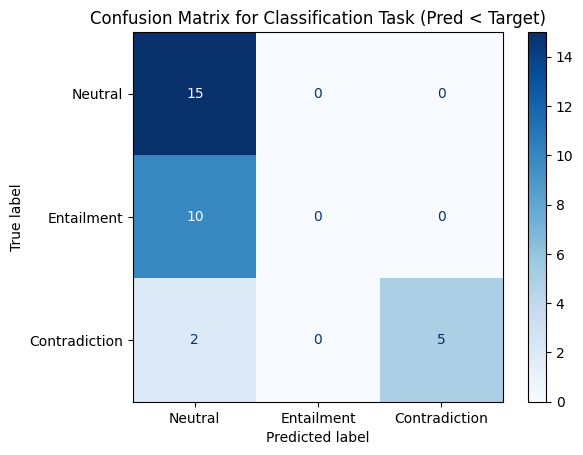

In [53]:
# Generate the confusion matrix
cm = confusion_matrix(results_df[reg_lwr_filt]['entailment_judgment'], results_df[reg_lwr_filt]['pred_cls'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Entailment', 'Contradiction'])
disp.plot(cmap='Blues')  # You can change the colormap if needed
plt.title("Confusion Matrix for Classification Task (Pred < Target)")
plt.show()

## Classification -> Regression

In [54]:
cls_filt = (results_df['entailment_judgment'] != results_df['pred_cls'])

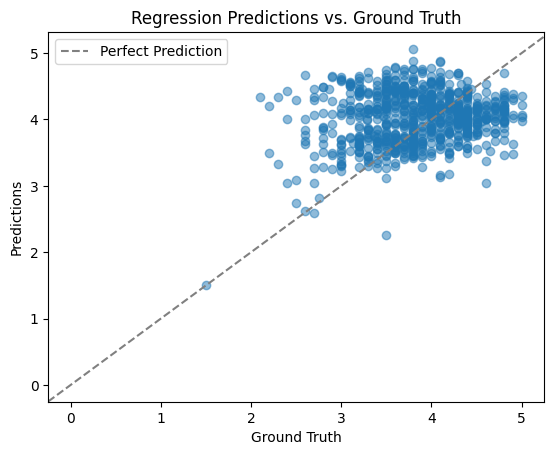

In [55]:
plt.scatter(results_df[cls_filt]['relatedness_score'], results_df[cls_filt]['pred_reg'], alpha=0.5)
plt.title("Regression Predictions vs. Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='Perfect Prediction')  # Reference line
plt.legend()
plt.show()

/tmp/ipykernel_83/72279230.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[cls_filt]['plot_color'] = results_df[cls_filt]['condition'].map(color_map)


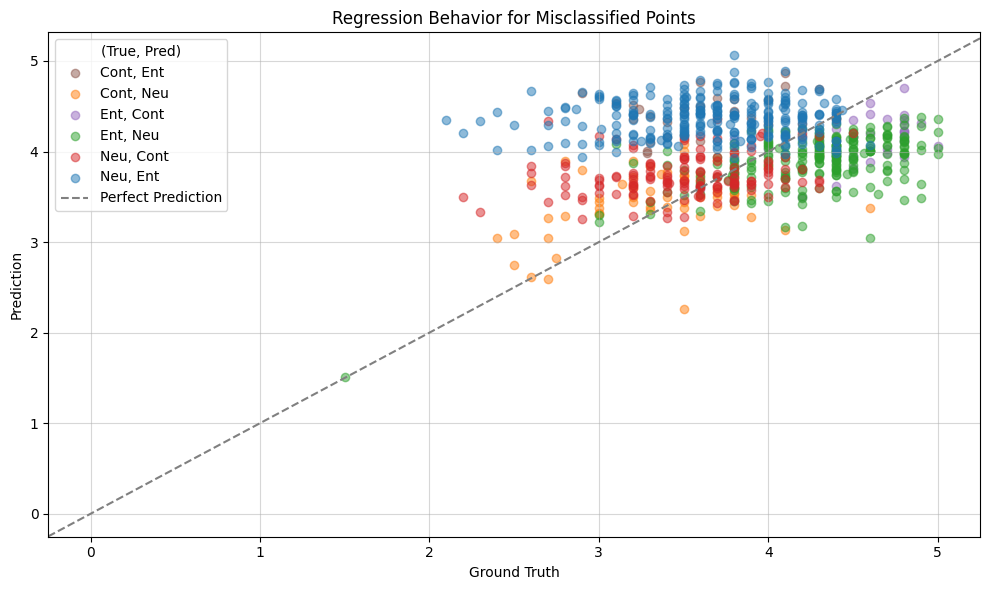

In [61]:
# Create a unique color for each (true i, pred j) condition
class_map = {0: 'Neu', 1: 'Ent', 2: 'Cont'}

results_df.loc[cls_filt, 'condition'] = results_df[cls_filt].apply(lambda row: f"{class_map[row['entailment_judgment']]}, {class_map[row['pred_cls']]}", axis=1)
unique_conditions = results_df[cls_filt]['condition'].unique()

# Map each condition to a color
color_map = {cond: plt.cm.tab10(i) for i, cond in enumerate(unique_conditions)}
results_df[cls_filt]['plot_color'] = results_df[cls_filt]['condition'].map(color_map)

# Plot regression predictions vs. ground truth for misclassified points
plt.figure(figsize=(10, 6))
for condition, group in results_df[cls_filt].groupby('condition'):
    plt.scatter(group['relatedness_score'], group['pred_reg'], 
                label=condition, color=color_map[condition], alpha=0.5)

# Add labels and legend
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Regression Behavior for Misclassified Points')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='Perfect Prediction')  # Reference line
plt.legend(title='(True, Pred)', loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [62]:
results_df[reg_filt & cls_filt]

,premise,hypothesis,relatedness_score,entailment_judgment,pred_reg,pred_cls,condition
sentence_pair_id,,,,,,,
21,A person in a black jacket is doing tricks on ...,A person on a black motorbike is doing tricks ...,3.0,0,4.580876,1,"Neu, Ent"
76,A little girl is looking at a woman in costume,A little girl in costume looks like a woman,2.9,0,4.085855,1,"Neu, Ent"
180,A large group of Asian people is eating at a r...,A group of people in a large Asian restaurant ...,3.5,0,4.529334,1,"Neu, Ent"
264,A cowgirl is riding a barrel near a horse in t...,A cowgirl is riding a horse and corners a barrel,2.8,0,4.333410,1,"Neu, Ent"
322,A man is in a parking lot and is playing tenni...,A lone man is in a parking lot and is playing ...,4.7,1,3.671459,0,"Ent, Neu"
...,...,...,...,...,...,...,...
9446,A woman wearing a blue shirt and high heels is...,A man and a woman are standing on the curb,4.2,1,3.177206,0,"Ent, Neu"
9588,The girl is painting a coverall blue,The girl in the blue coverall is painting,3.2,0,4.424446,1,"Neu, Ent"
9690,A bicyclist is performing a trick over a clean...,A bicyclist is performing a trick over a heavi...,3.3,0,4.622370,1,"Neu, Ent"
